In [ ]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import numpy as np
import re
import seaborn as sns
import time
import requests
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
from google.colab import files
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

pd.set_option('display.max_columns', None)

from google.colab import drive
drive.mount('/content/gdrive')
path = '/content/gdrive/MyDrive/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Modeling with selected features

In [ ]:
df = pd.read_csv(path + './ph_fires_matched_2.1.csv')
df = df[
    (df.building_type_code_es == 1)
]
df = df.drop(['objectid', 'corrected_address', 'corrected_unit', 'std_city', 'std_st', 'std_zip5'], axis=1)

# Remove imputed development-level and public housing agency-level columns.
df = df[[x for x in df.columns if 'pha_' not in x and 'dev_' not in x]]

In [ ]:
start_year = 2012
stop_year = 2017

df['inc_type_111_2018_2019'] = (df.inc_type_111_2018 + df.oth_inj_2018 + df.prop_loss_2018 + df.cont_loss_2018) + (df.inc_type_111_2019 + df.oth_inj_2019 + df.prop_loss_2019 + df.cont_loss_2019)
df['inc_type_111_2020_2021'] = (df.inc_type_111_2020 + df.oth_inj_2020 + df.prop_loss_2020 + df.cont_loss_2020) + (df.inc_type_111_2021  + df.oth_inj_2021 + df.prop_loss_2021 + df.cont_loss_2021)

for col in [f'inc_type_111_2018_2019', f'inc_type_111_2020_2021']:
  df[col] = df[col] > 0

df[f'det_alert_{start_year}_{stop_year}'] = df[[f'det_alert_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
df[f'aes_pres_{start_year}_{stop_year}'] = df[[f'aes_pres_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
df[f'sum_flame_sprd_{start_year}_{stop_year}'] = df[[f'flame_sprd_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
df[f'sum_building_fires_{start_year}_{stop_year}'] = df[[f'building_fires_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
df[f'sum_unconfined_{start_year}_{stop_year}'] = df[[f'inc_type_111_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
df[f'sum_inj_{start_year}_{stop_year}'] = df[[f'oth_inj_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)
df[f'sum_money_lost_{start_year}_{stop_year}'] = df[[f'prop_loss_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1) + df[[f'cont_loss_{year}' for year in range(start_year, stop_year + 1)]].sum(axis=1)

In [ ]:
selected_cols = [
'inc_type_111_2018_2019',
'inc_type_111_2020_2021',

f'det_alert_{start_year}_{stop_year}',
f'aes_pres_{start_year}_{stop_year}',
f'sum_flame_sprd_{start_year}_{stop_year}',
f'sum_building_fires_{start_year}_{stop_year}',
f'sum_unconfined_{start_year}_{stop_year}',
f'sum_inj_{start_year}_{stop_year}',
f'sum_money_lost_{start_year}_{stop_year}',

'total_dwelling_units',
 'acc_units',
 'total_occupied',
 'regular_vacant',
 'total_units',
 'pct_occupied',
 'number_reported',
 'pct_reported',
 'months_since_report',
 'pct_movein',
 'people_per_unit',
 'people_total',
 'rent_per_month',
 'spending_per_month',
 'spending_per_month_prev_yr',
 'hh_income',
 'person_income',
 'pct_lt5k',
 'pct_5k_lt10k',
 'pct_10k_lt15k',
 'pct_15k_lt20k',
 'pct_ge20k',
 'pct_wage_major',
 'pct_welfare_major',
 'pct_other_major',
 'pct_median',
 'pct_lt50_median',
 'pct_lt30_median',
 'pct_2adults',
 'pct_1adult',
 'pct_female_head',
 'pct_female_head_child',
 'pct_disabled_lt62',
 'pct_disabled_ge62',
 'pct_disabled_all',
 'pct_lt24_head',
 'pct_age25_50',
 'pct_age51_61',
 'pct_age62plus',
 'pct_age85plus',
 'pct_minority',
 'pct_black',
 'pct_native_american',
 'pct_asian',
 'pct_hispanic',
 'months_waiting',
 'months_from_movein',
 'pct_utility_allow',
 'ave_util_allow',
 'pct_bed1',
 'pct_bed2',
 'pct_bed3',
 'pct_overhoused',
 'tminority',
 'tpoverty',
 'tpct_ownsfd',
 'chldrn_mbr_cnt',
 'eldly_prcnt',
 'pct_disabled_lt62_all',
 'pct_lt80_median',
 'median_inc_amnt',
 'metro',
 'micro',
 'c1pprb',
 'annl_expns_amnt',
 'annl_expns_amnt_prev_yr',
 'construction_year',
 'dofa_actual_year',
 'encoded_development_code',
 'encoded_participant_code',
 'encoded_msa_nm',
 'encoded_zip5',
 'encoded_zip9',
 'encoded_zip11',
 'msgusps_100% overall probable correctness',
 'msgusps_20% overall probable correctness',
 'msgusps_30% overall probable correctness',
 'msgusps_40% overall probable correctness',
 'msgusps_50% overall probable correctness',
 'msgusps_60% overall probable correctness',
 'msgusps_70% overall probable correctness',
 'msgusps_80% overall probable correctness',
 'msgusps_90% overall probable correctness',
 'msgusps_apartment missing or not found',
 'msgusps_house # not found on this street',
 'msgusps_insufficient or blank address',
 'msgusps_multiple match',
 'msgusps_street not found',
 'building_type_code_es',
 'building_type_code_nds',
 'building_type_code_rw',
 'building_type_code_sd',
 'building_type_code_sf',
 'building_type_code_wu',
 'addr_type_f',
 'addr_type_g',
 'addr_type_h',
 'addr_type_missing_value',
 'addr_type_p',
 'addr_type_r',
 'addr_type_s',
 'building_status_type_code_ddaprd',
 'building_status_type_code_dddrft',
 'building_status_type_code_ddprop',
 'building_status_type_code_inapcp',
 'building_status_type_code_rmi',
 'building_status_type_code_rmiprp',
 'apt_type_#',
 'apt_type_apt',
 'apt_type_lot',
 'apt_type_missing_value',
 'apt_type_ste',
 'apt_type_unit',
 'lvl2kx_4',
 'lvl2kx_5',
 'lvl2kx_b',
 'lvl2kx_missing_value',
 'lvl2kx_r',
 'lvl2kx_t',
 'rad_type_ ',
 'rad_type_pbra',
 'rad_type_pbv',
 'rad_type_pbv/pbra',
 'rad_chap_indr_n',
 'rad_chap_indr_y',
 'ur_missing_value',
 'ur_r',
 'ur_u',
 'zip_class_missing_value',
 'zip_class_p',
 'zip_class_u',
 'last_updt_dttm_2023/03/06 08:50:52+00',
 'encoded_city',
 'std_st_ak',
 'std_st_al',
 'std_st_ar',
 'std_st_az',
 'std_st_ca',
 'std_st_co',
 'std_st_ct',
 'std_st_dc',
 'std_st_de',
 'std_st_fl',
 'std_st_ga',
 'std_st_gu',
 'std_st_hi',
 'std_st_ia',
 'std_st_id',
 'std_st_il',
 'std_st_in',
 'std_st_ks',
 'std_st_ky',
 'std_st_la',
 'std_st_ma',
 'std_st_md',
 'std_st_me',
 'std_st_mi',
 'std_st_missing_value',
 'std_st_mn',
 'std_st_mo',
 'std_st_ms',
 'std_st_mt',
 'std_st_nc',
 'std_st_nd',
 'std_st_ne',
 'std_st_nh',
 'std_st_nj',
 'std_st_nm',
 'std_st_nv',
 'std_st_ny',
 'std_st_oh',
 'std_st_ok',
 'std_st_or',
 'std_st_pa',
 'std_st_pr',
 'std_st_ri',
 'std_st_sc',
 'std_st_sd',
 'std_st_tn',
 'std_st_tx',
 'std_st_ut',
 'std_st_va',
 'std_st_vi',
 'std_st_vt',
 'std_st_wa',
 'std_st_wi',
 'std_st_wv',
 'std_st_wy',

 ]

selected_df = df[selected_cols]
selected_df.shape

(4021, 197)

In [ ]:
drop_for_being_zero_importance = [
    'msgusps_30% overall probable correctness', 'msgusps_50% overall probable correctness', 'msgusps_40% overall probable correctness', 'msgusps_apartment missing or not found',
    'msgusps_20% overall probable correctness', 'msgusps_100% overall probable correctness', 'sum_inj_2012_2017', 'metro', 'pct_utility_allow', 'pct_female_head_child', 'std_st_wy',
    'msgusps_house # not found on this street', 'std_st_ms', 'std_st_mn', 'std_st_missing_value',
    'std_st_mi', 'std_st_me', 'std_st_md', 'std_st_la', 'std_st_ks', 'std_st_in', 'std_st_id', 'std_st_ia', 'std_st_hi', 'std_st_gu', 'std_st_ga', 'std_st_fl', 'std_st_de', 'std_st_dc', 'std_st_co', 'std_st_ca', 'std_st_az', 'std_st_mo', 'std_st_mt',
    'msgusps_insufficient or blank address', 'std_st_nc', 'std_st_wi', 'std_st_wa', 'std_st_vt', 'std_st_vi', 'std_st_va', 'std_st_ut', 'std_st_tn', 'std_st_sd', 'std_st_sc', 'std_st_ri', 'std_st_pr', 'std_st_pa', 'std_st_or', 'std_st_ok', 'std_st_nv', 'std_st_nm',
    'std_st_nh', 'std_st_ne', 'std_st_nd', 'std_st_ar', 'std_st_al', 'std_st_ak', 'last_updt_dttm_2023/03/06 08:50:52+00', 'building_status_type_code_rmi',
    'building_status_type_code_ddprop', 'building_status_type_code_dddrft',
    'building_status_type_code_ddaprd', 'addr_type_s', 'addr_type_r', 'addr_type_p', 'addr_type_missing_value', 'addr_type_h', 'addr_type_g', 'addr_type_f', 'building_type_code_wu', 'building_type_code_sf', 'building_type_code_sd', 'std_st_wv',
    'building_type_code_nds', 'building_type_code_es', 'msgusps_street not found', 'msgusps_multiple match', 'building_status_type_code_rmiprp', 'apt_type_#', 'apt_type_lot', 'rad_type_pbv/pbra', 'zip_class_u', 'zip_class_p', 'zip_class_missing_value', 'ur_u', 'ur_r', 'ur_missing_value',
    'rad_chap_indr_y', 'rad_chap_indr_n', 'rad_type_pbra', 'apt_type_missing_value', 'lvl2kx_t', 'lvl2kx_r', 'lvl2kx_missing_value', 'lvl2kx_b', 'lvl2kx_5', 'lvl2kx_4', 'apt_type_unit', 'apt_type_ste', 'building_type_code_rw',
    'msgusps_70% overall probable correctness',
    'msgusps_60% overall probable correctness',
    'apt_type_apt',
    'rad_type_pbv',
    'std_st_ct',
    'std_st_ky',
    'std_st_ma',
     "msgusps_100% overall probable correctness",
    "std_st_wy",
    "msgusps_30% overall probable correctness",
    "sum_inj_2012_2017",
    "msgusps_20% overall probable correctness",
    "building_type_code_rw",
    "msgusps_40% overall probable correctness",
    "std_st_ct",
    "std_st_la",
    "std_st_id",
    "std_st_ia",
    "std_st_hi",
    "std_st_gu",
    "std_st_ga",
    "std_st_fl",
    "std_st_de",
    "std_st_co",
    "msgusps_50% overall probable correctness",
    "std_st_ca",
    "std_st_az",
    "std_st_ar",
    "std_st_al",
    "std_st_ak",
    "last_updt_dttm_2023/03/06 08:50:52+00",
    "zip_class_u",
    "zip_class_p",
    "std_st_ma",
    "std_st_missing_value",
    "std_st_mn",
    "std_st_ms",
    "std_st_wa",
    "std_st_vt",
    "std_st_vi",
    "std_st_va",
    "std_st_ut",
    "std_st_sd",
    "std_st_sc",
    "std_st_ri",
    "std_st_pr",
    "std_st_or",
    "std_st_ok",
    "std_st_nv",
    "std_st_nm",
    "std_st_nh",
    "std_st_ne",
    "std_st_nd",
    "std_st_mt",
    "zip_class_missing_value",
    "ur_u",
    "ur_r",
    "building_status_type_code_dddrft",
    "addr_type_r",
    "addr_type_p",
    "addr_type_missing_value",
    "addr_type_g",
    "addr_type_f",
    "building_type_code_wu",
    "building_type_code_sf",
    "building_type_code_sd",
    "std_st_wv",
    "building_type_code_nds",
    "building_type_code_es",
    "msgusps_street not found",
    "msgusps_multiple match",
    "msgusps_insufficient or blank address",
    "msgusps_house # not found on this street",
    "msgusps_apartment missing or not found",
    "msgusps_80% overall probable correctness",
    "building_status_type_code_ddaprd",
    "building_status_type_code_rmi",
    "ur_missing_value",
    "building_status_type_code_rmiprp",
    "rad_chap_indr_y",
    "rad_chap_indr_n",
    "rad_type_pbv/pbra",
    "rad_type_pbra",
    "lvl2kx_t",
    "lvl2kx_r",
    "lvl2kx_missing_value",
    "lvl2kx_b",
    "lvl2kx_5",
    "lvl2kx_4",
    "apt_type_unit",
    "apt_type_ste",
    "apt_type_missing_value",
    "apt_type_lot",
    "apt_type_apt",
    "apt_type_#",
    "det_alert_2012_2017",
    'building_status_type_code_inapcp',
    'std_st_il',
    'pct_reported',
    'pct_native_american',
    'std_st_tx'
]
selected_df = selected_df.drop(drop_for_being_zero_importance, axis=1)
selected_df.shape

(4021, 82)

In [ ]:
train_cols = [x for x in selected_df.columns if '2018' in x or '2019' in x]
test_cols = [x for x in selected_df.columns if '2020' in x or '2021' in x]

# Remove all 2021 and 2020 data
X_train = selected_df.drop(test_cols + train_cols, axis=1)
X_train = X_train.fillna(X_train.mean())

display(X_train.sample())

# Train on 2020 fires with supervised learning
y_train = selected_df[f'inc_type_111_2018_2019']

# Reserve 2021 as validation
y_test = selected_df[f'inc_type_111_2020_2021']

# X_train_scaled = StandardScaler().fit_transform(X_train)
X_train_scaled = X_train
# X_train_resampled, y_train_resampled = SMOTE(random_state=538).fit_resample(X_train_scaled, y_train)
X_train_resampled = X_train_scaled
y_train_resampled = y_train

print(len(X_train_resampled))

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'max_depth': [5, 10, 20, 50, 75, 100, 125, 150, 300, None],
    # 'max_features': ['sqrt', 'log2'],
    'class_weight': [{0: 1, 1: 1}, {0: 1, 1: 2}, {0: 1, 1: 3}, {0: 1, 1: 4}, {0: 1, 1: 5}, {0: 1, 1: 10}, {0: 1, 1: 15}],

    'min_samples_split': [2, 3, 6, 7, .01, .05, .01],
    'min_samples_leaf': [1, 2, 4, 5, 7, .0001, .001, .01, .05]
}

custom_f1_scorer = make_scorer(f1_score, pos_label=True)

# # Create the Random Forest model
model = RandomForestClassifier(n_estimators=500, random_state=538,
                               max_depth=15, class_weight={0: 1, 1: 10})
model.fit(X_train_resampled, y_train_resampled)

# d = DecisionTreeClassifier()
# grid_search = GridSearchCV(estimator=d, param_grid=param_grid, scoring=custom_f1_scorer, n_jobs=-1, cv=10)

# # Fit the grid search to the data
# grid_search.fit(X_train_resampled, y_train_resampled)

# # Get the best estimator and parameters
# model = grid_search.best_estimator_

# print("Best parameters:", grid_search.best_params_)


,aes_pres_2012_2017,sum_flame_sprd_2012_2017,sum_building_fires_2012_2017,sum_unconfined_2012_2017,sum_money_lost_2012_2017,total_dwelling_units,acc_units,total_occupied,regular_vacant,total_units,pct_occupied,number_reported,months_since_report,pct_movein,people_per_unit,people_total,rent_per_month,spending_per_month,spending_per_month_prev_yr,hh_income,person_income,pct_lt5k,pct_5k_lt10k,pct_10k_lt15k,pct_15k_lt20k,pct_ge20k,pct_wage_major,pct_welfare_major,pct_other_major,pct_median,pct_lt50_median,pct_lt30_median,pct_2adults,pct_1adult,pct_female_head,pct_disabled_lt62,pct_disabled_ge62,pct_disabled_all,pct_lt24_head,pct_age25_50,pct_age51_61,pct_age62plus,pct_age85plus,pct_minority,pct_black,pct_asian,pct_hispanic,months_waiting,months_from_movein,ave_util_allow,pct_bed1,pct_bed2,pct_bed3,pct_overhoused,tminority,tpoverty,tpct_ownsfd,chldrn_mbr_cnt,eldly_prcnt,pct_disabled_lt62_all,pct_lt80_median,median_inc_amnt,micro,c1pprb,annl_expns_amnt,annl_expns_amnt_prev_yr,construction_year,dofa_actual_year,encoded_development_code,encoded_participant_code,encoded_msa_nm,encoded_zip5,encoded_zip9,encoded_zip11,msgusps_90% overall probable correctness,rad_type_,encoded_city,std_st_nj,std_st_ny,std_st_oh
147226,0.0,0.0,0.0,0.0,0.0,18,8,8,0,18,44.439999,8,7.266999,7.699362,1.551405,118.134681,426.009189,868.196902,677.191651,18538.609084,12435.078498,5.27273,11.900236,40.365332,13.917816,28.543725,20.467705,4.348278,72.651281,20.892586,93.042339,77.606847,1.190798,13.792058,65.839535,51.527761,55.095272,45.405999,1.725261,23.008971,22.046482,53.219236,4.984269,69.053135,37.055729,4.069575,27.254274,10.467314,174.934366,13.01864,62.715983,25.550034,11.73409,15.137459,62.268099,30.187994,24.590767,18.828564,45.285975,22.326414,98.599312,14252.822788,0.0,1.0,875530.533473,696545.812105,1982.0,2017.0,6278,2611,38,5774,4050,165882,1,1,374,0,0,0


4021


RandomForestClassifier(class_weight={0: 1, 1: 10}, max_depth=15,
                       n_estimators=500, random_state=538)

In [ ]:
# from sklearn.tree import export_graphviz
# import graphviz

# dot_data = export_graphviz(model, out_file=None,
#                            feature_names=X_train_resampled.columns,
#                            class_names=['No Fires', 'Yes Fires'],
#                            filled=True, rounded=True, special_characters=True)

# dot_data = dot_data.replace('shape=box', 'shape=box, width=0.3, height=0.3')
# graph = graphviz.Source(dot_data)
# graph.view()
# graph.render('tree_plot')

In [ ]:
y_pred = model.predict(X_train_scaled)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

       False       0.96      0.97      0.96      3839
        True       0.24      0.23      0.23       182

    accuracy                           0.93      4021
   macro avg       0.60      0.60      0.60      4021
weighted avg       0.93      0.93      0.93      4021



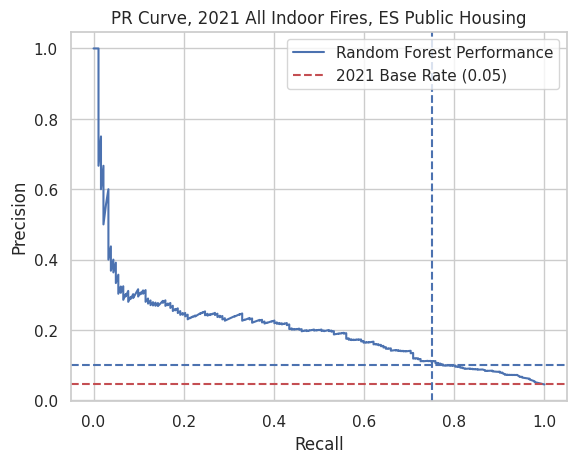

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = model.predict_proba(X_train_scaled)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(recall, precision, label="Random Forest Performance")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("PR Curve, 2021 All Indoor Fires, ES Public Housing")
base_rate = len(df[df.inc_type_111_2020_2021]) / len(df)
plt.axhline(base_rate, color='r', linestyle='--', label=f'2021 Base Rate ({round(base_rate, 2)})')
plt.axhline(.1, color='b', linestyle='--')
plt.axvline(.75, color='b', linestyle='--')

plt.legend()
plt.show()


In [ ]:
feature_names = X_train.columns
importances = model.feature_importances_
sorted_indices = np.argsort(importances)[::-1]
for i in sorted_indices:
    print(f"{feature_names[i]}: {importances[i]}")


sum_building_fires_2012_2017: 0.05004461317762599
aes_pres_2012_2017: 0.04583390153583646
sum_money_lost_2012_2017: 0.03888788073036036
pct_median: 0.027273074371815018
pct_disabled_all: 0.024617041744531522
total_dwelling_units: 0.0198468203673376
encoded_zip11: 0.01929167011817707
total_units: 0.01906759582553967
pct_female_head: 0.017952126760712377
encoded_zip5: 0.017716749431481424
pct_ge20k: 0.01731630495873127
pct_10k_lt15k: 0.01729299837712201
encoded_development_code: 0.016636836761049847
pct_disabled_ge62: 0.01620494092488825
pct_disabled_lt62: 0.015661980133340078
acc_units: 0.015138145348344408
hh_income: 0.01506706209995051
pct_lt50_median: 0.015023495041970413
total_occupied: 0.015002251420531545
tminority: 0.014881231339865379
sum_flame_sprd_2012_2017: 0.014863447698780676
pct_disabled_lt62_all: 0.014590237892486518
pct_occupied: 0.014207031193828134
months_from_movein: 0.014132414719112068
annl_expns_amnt_prev_yr: 0.01406652833972723
encoded_participant_code: 0.01403609

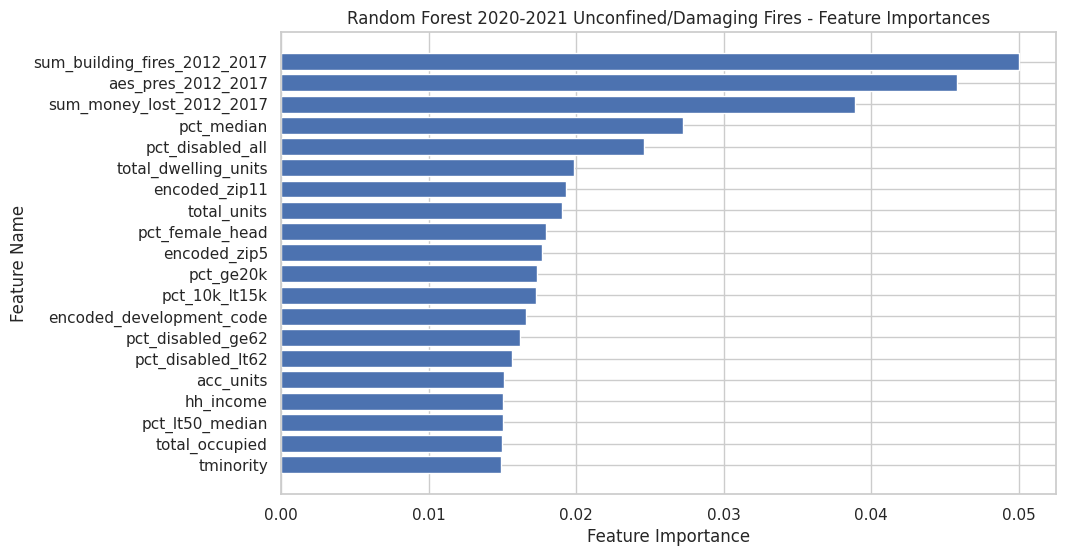

In [ ]:
features = [feature_names[i] for i in sorted_indices[:20]]
coeffs = [importances[i] for i in sorted_indices[:20]]
plt.figure(figsize=(10, len(features) * 0.3))
plt.barh(features, coeffs)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Random Forest 2020-2021 Unconfined/Damaging Fires - Feature Importances')
plt.gca().invert_yaxis()
plt.show()

In [ ]:
probabilities = model.predict_proba(X_train_scaled)
fire_probabilities = probabilities[:, 1]

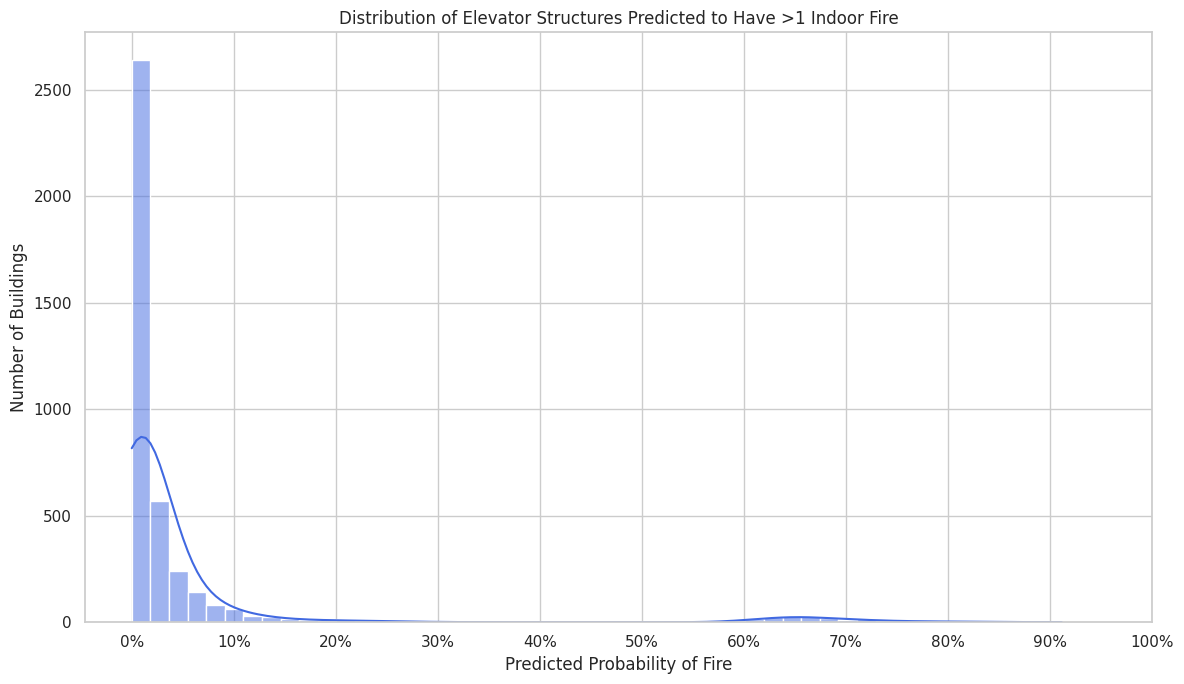

In [ ]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 7))
sns.histplot(fire_probabilities, bins=50, color='royalblue', kde=True, edgecolor='w')
plt.xlabel('Predicted Probability of Fire')
plt.ylabel('Number of Buildings')
plt.title('Distribution of Elevator Structures Predicted to Have >1 Indoor Fire')
plt.xticks(ticks=[i/100 for i in range(0, 101, 10)], labels=[f'{i}%' for i in range(0, 101, 10)])
plt.tight_layout()
plt.show()


In [ ]:
# df_display = pd.read_csv(path + './ph_fires_matched_2.1.csv')

# df_display = df_display[
#     (df_display.building_type_code_es == 1)
# ]

# df_display['fire_probability'] = fire_probabilities
# df_display.to_csv('lr_es_type1_probs.csv', index=False)
# files.download('lr_es_type1_probs.csv')